In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
plt.style.use('dark_background')

In [15]:
import scipy.stats
from sklearn.metrics import mean_squared_error

# TASK_TYPE = "detection_per_ion"
TASK_TYPE = "detection_per_mol"


plots_dir = Path.cwd() / "../plots"
results_dir = Path.cwd() / "../results" / TASK_TYPE


## Evaluation of classification


In [16]:
filenames = {
    "all_feat": "results_all_feat.csv",
    "fingerprints_feat": "results_fingerprints_feat.csv",
    "mol_feat": "results_mol_feat.csv",
    "random_feat": "results_random_feat.csv",
    # "no_feat": "results_no_features.csv",
}


In [17]:
metric = "macro_avg_f1_score"

# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                                            'det_precision', 'det_recall', 'det_f1', 'detected', 'macro_avg_f1_score']
models_results = pd.DataFrame()
model_metrics = pd.DataFrame(columns = ['matrix', 'polarity', 'model_type', 'train_setup'] + score_cols)
model_performance = pd.DataFrame()
counter = 0

for training_setup in filenames:
    result_filename = filenames[training_setup]
    loc_models_results = pd.read_csv(results_dir / result_filename, index_col = 0)
    loc_models_results.observed_value = np.where(loc_models_results.observed_value, 1, 0)

    # -----------------------------------------
    # Add extra baseline randomly guessing:
    # -----------------------------------------

    baseline_results = loc_models_results.drop(columns=["classifier", "prediction", "fold"]).drop_duplicates().reset_index(drop=True)
    baseline_results["prediction"] = 0
    baseline_results["fold"] = 0
    baseline_results["classifier"] = "random_guess"

    for (matrix, polarity), rows in baseline_results.groupby(['matrix', 'polarity']):
        detected_prob = float(rows["observed_value"].sum()) / len(rows)
        prediction = (np.random.random(size=len(rows)) < detected_prob).astype('int')
        baseline_results.loc[rows.index.to_list(), "prediction"] = prediction

    loc_models_results = pd.concat([loc_models_results, baseline_results])


    for (matrix, polarity, classifier), rows in loc_models_results.groupby(['matrix', 'polarity', 'classifier']):

        clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
        if rows.observed_value.max() == 0:
            print("no detection!")
        model_metrics.loc[counter] = [matrix, polarity, classifier, training_setup,
                                          clf_report['0']['precision'], clf_report['0']['recall'],
                                          clf_report['0']['f1-score'], clf_report['0']['support'],
                                          clf_report['1']['precision'], clf_report['1']['recall'],
                                          clf_report['1']['f1-score'], clf_report['1']['support'],
                                          clf_report['macro avg']['f1-score']
                                          ]
        counter += 1

    loc_models_results["train_setup"] = training_setup
    models_results = pd.concat([models_results, loc_models_results])

    # FInd best model across matrices:
    loc_model_performance = pd.DataFrame()
    for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
        rows["difference"] = rows[metric] - rows[metric].max()
        loc_model_performance = pd.concat([loc_model_performance, rows[["model_type", "difference"]]])

    loc_model_performance = loc_model_performance.groupby(["model_type"]).sum()
    loc_model_performance["train_setup"] = training_setup
    model_performance = pd.concat([model_performance, loc_model_performance])



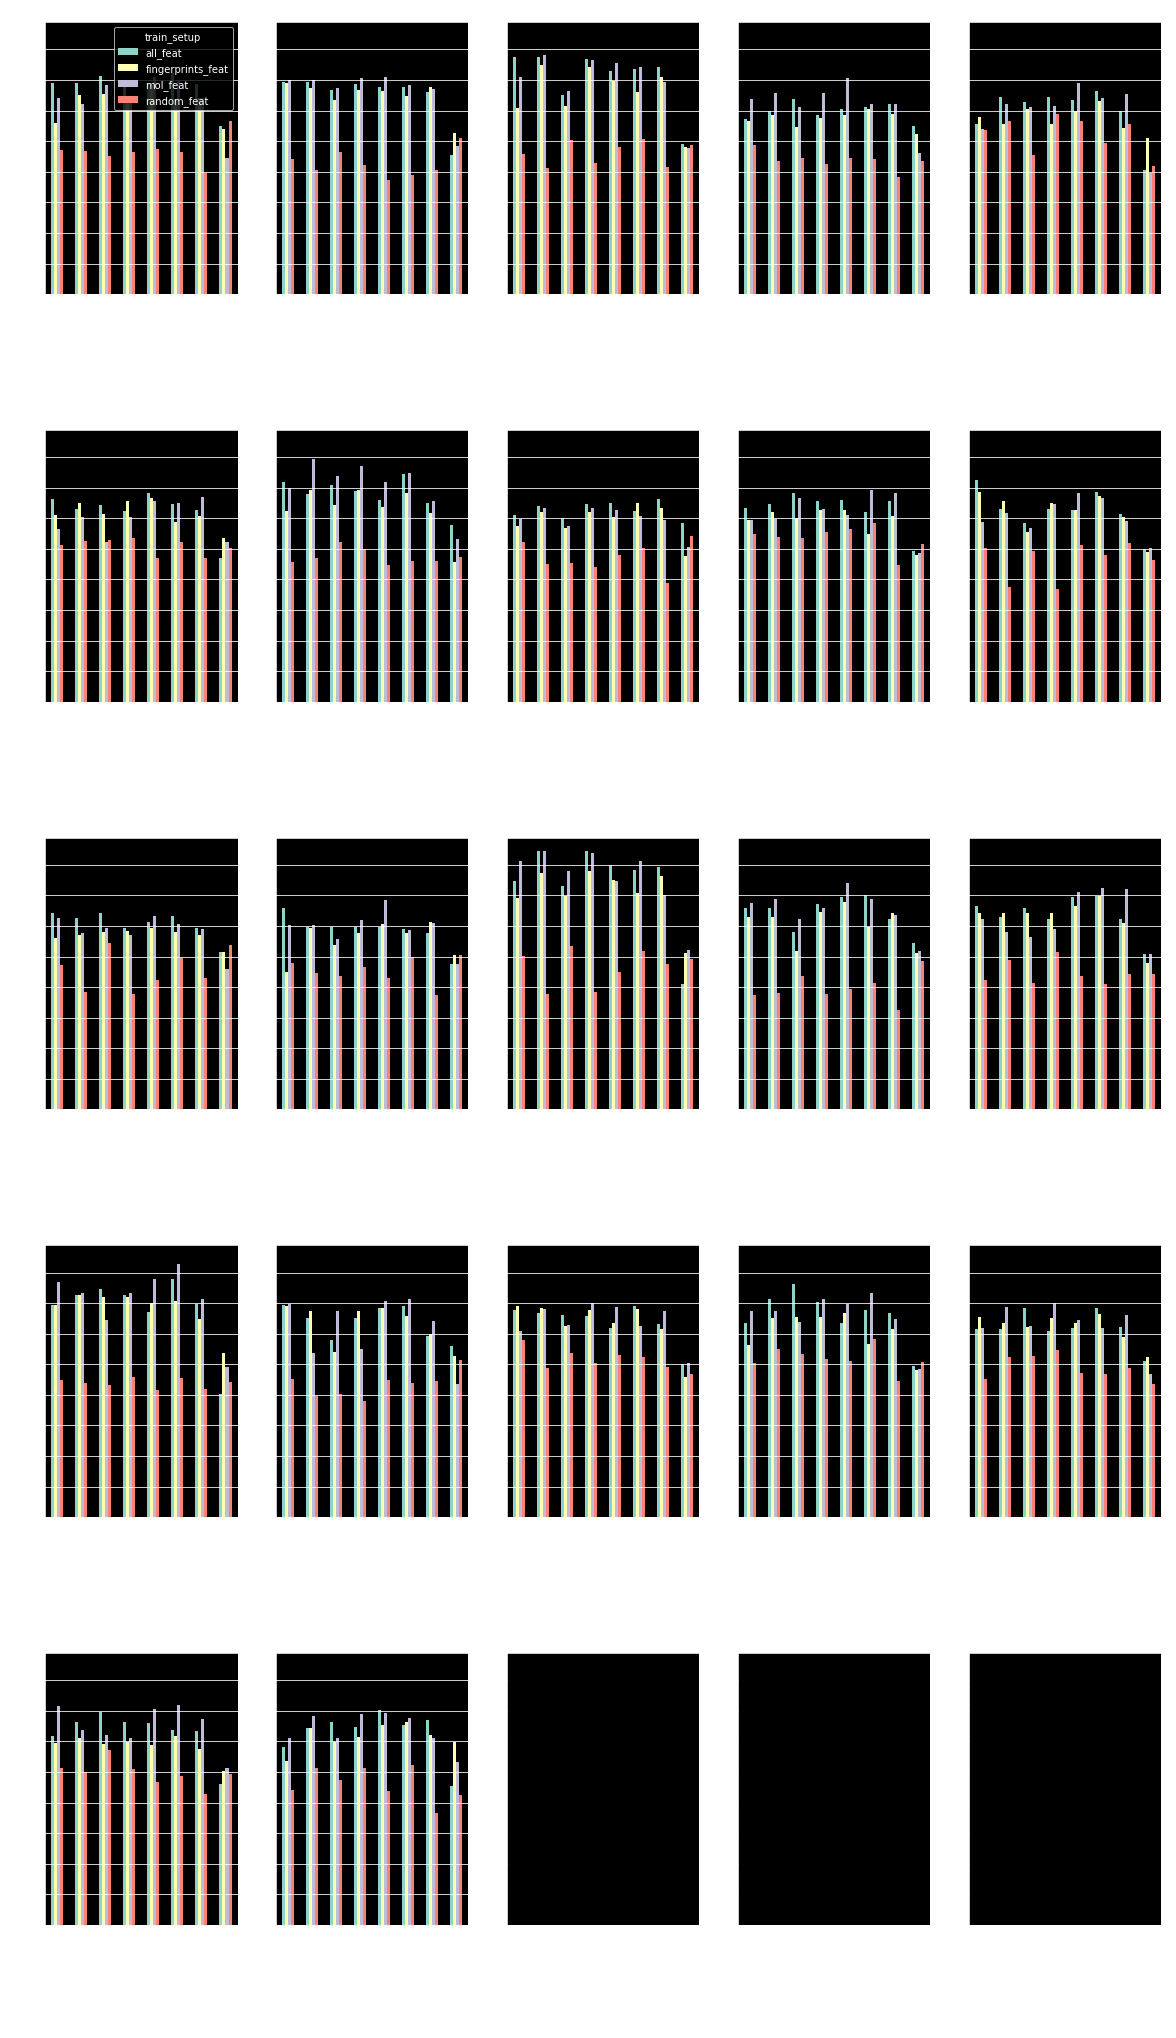

In [18]:

fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

# metric = "Spearman's R"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
    nb_obs = rows['detected'].drop_duplicates().values[0]
    rows = rows.set_index(["model_type", 'train_setup'], drop = True).sort_values( by = ["model_type", metric])
    rows = rows.unstack("train_setup")
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    if i != 0:
        ax_list[i].legend(loc="lower right")
        ax_list[i].get_legend().set_visible(False)
        # ax_list[i].get_legend().set_visible(False)
    i+=1

plt.subplots_adjust(hspace=0.5)
plt.show()

